C:\Users\Eyasu\AppData\Local\Temp\ipykernel_15320\3859419199.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=iv_df, x='IV', y='Feature', palette='viridis')


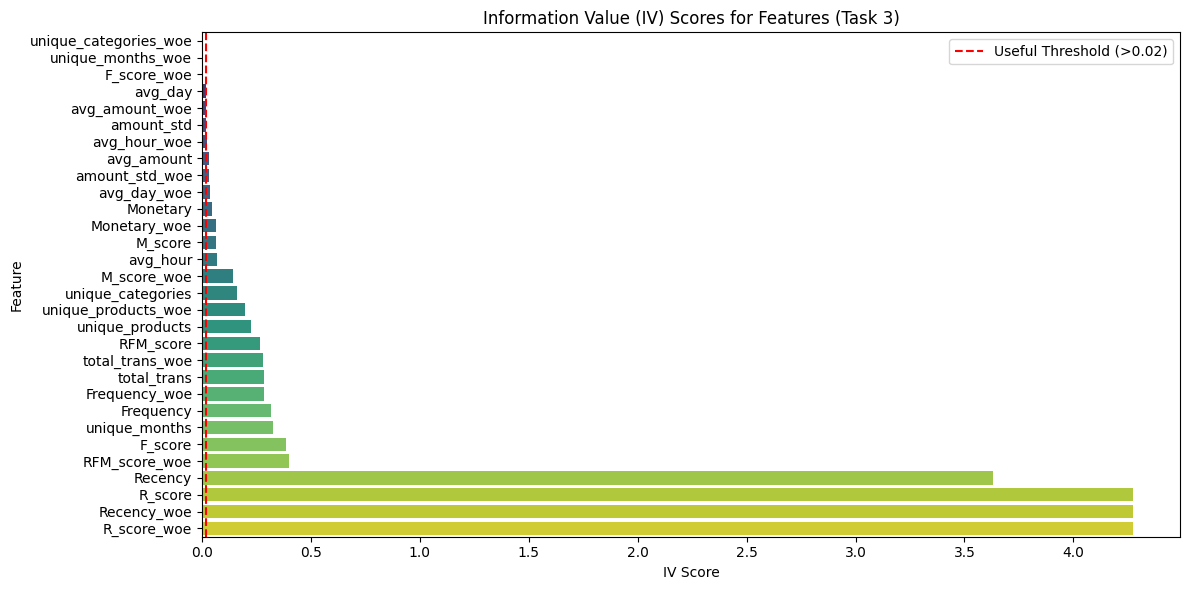

                  Feature        IV
26  unique_categories_woe  0.000000
29      unique_months_woe  0.000000
19            F_score_woe  0.000000
13                avg_day  0.017093
24         avg_amount_woe  0.019814
8              amount_std  0.019959
27           avg_hour_woe  0.023253
9              avg_amount  0.030901
23         amount_std_woe  0.033942
28            avg_day_woe  0.035483
2                Monetary  0.047288
17           Monetary_woe  0.064214
5                 M_score  0.064214
12               avg_hour  0.066909
20            M_score_woe  0.144166
11      unique_categories  0.160669
25    unique_products_woe  0.198554
10        unique_products  0.226090
6               RFM_score  0.265944
22        total_trans_woe  0.281978
7             total_trans  0.282232
15          Frequency_woe  0.283155
0               Frequency  0.314705
14          unique_months  0.326328
4                 F_score  0.387006
21          RFM_score_woe  0.398777
1                 Recency  3

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

# Fix path for src import (run from notebooks/)
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))  # Add project root

from src.data_processing import calculate_iv  # Corrected import

# Load data
features = pd.read_csv('../data/processed/credit_features_engineered.csv')
target_col = 'is_high_risk'

# Recompute IV
numeric_cols = features.select_dtypes(include=[np.number]).columns.drop(target_col)
iv_scores = {}
for feat in numeric_cols:
    iv = calculate_iv(features, feat, target_col)
    iv_scores[feat] = iv

iv_df = pd.DataFrame(list(iv_scores.items()), columns=['Feature', 'IV']).sort_values('IV', ascending=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=iv_df, x='IV', y='Feature', palette='viridis')
plt.title('Information Value (IV) Scores for Features (Task 3)')
plt.xlabel('IV Score')
plt.axvline(x=0.02, color='red', linestyle='--', label='Useful Threshold (>0.02)')
plt.legend()
plt.tight_layout()
# plt.savefig('../../reports/figures/task3_iv_scores.png', dpi=300, bbox_inches='tight')  # Adjust path if needed
plt.show()

print(iv_df)

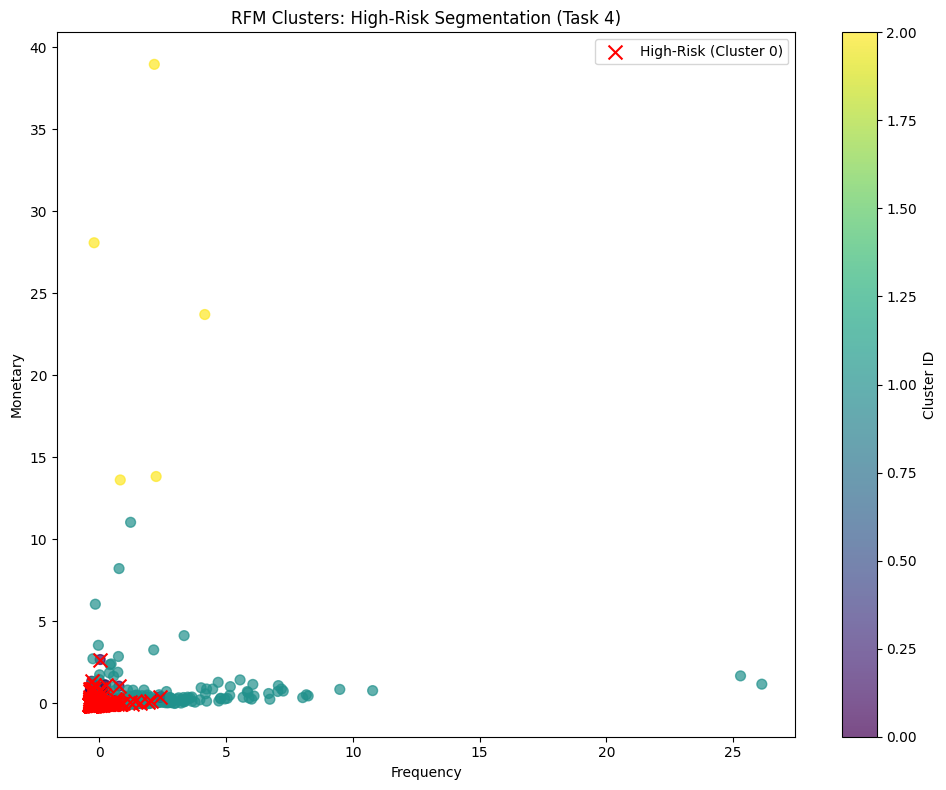

         Frequency   Monetary  is_high_risk
cluster                                    
0        -0.266457  -0.069724           1.0
1         0.168077  -0.008562           0.0
2         1.832362  23.629559           0.0


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data (ensures 'features' is defined)
features = pd.read_csv('../data/processed/credit_features_engineered.csv')

# RFM subset
rfm_data = features[['Recency', 'Frequency', 'Monetary', 'is_high_risk']].copy()
# Reverse Recency (lower = better)
rfm_data['Recency_scaled'] = -rfm_data['Recency']

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency_scaled', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=features.index)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm_data['cluster'] = kmeans.fit_predict(rfm_scaled_df)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(rfm_data['Frequency'], rfm_data['Monetary'], 
                      c=rfm_data['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='Cluster ID')
plt.scatter(rfm_data[rfm_data['is_high_risk']==1]['Frequency'], 
            rfm_data[rfm_data['is_high_risk']==1]['Monetary'], 
            color='red', s=100, marker='x', label='High-Risk (Cluster 0)')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('RFM Clusters: High-Risk Segmentation (Task 4)')
plt.legend()
plt.tight_layout()
# plt.savefig('../../reports/figures/task4_rfm_clusters.png', dpi=300, bbox_inches='tight')  # Saves to project root
plt.show()

# Summary
print(rfm_data.groupby('cluster')[['Frequency', 'Monetary', 'is_high_risk']].mean())

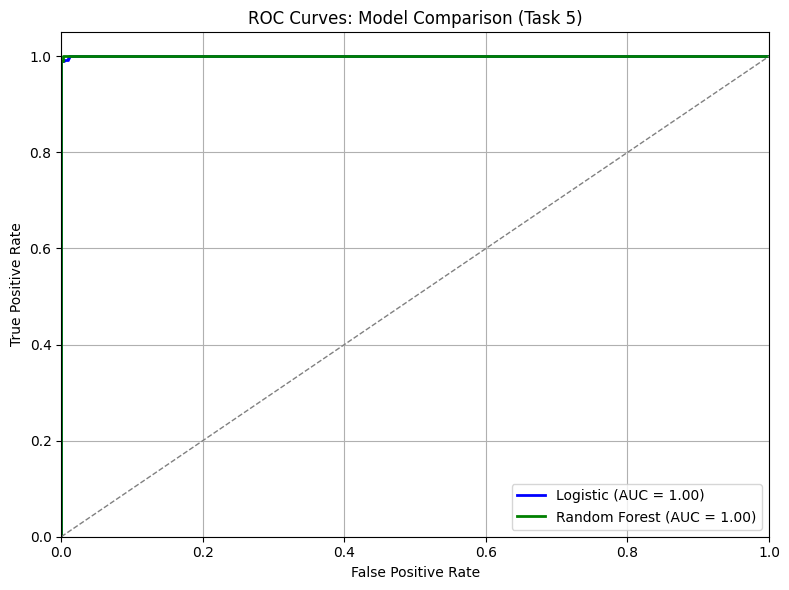

Logistic AUC: 0.9999
Random Forest AUC: 1.0000


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Load real data (or synthetic)
features = pd.read_csv('../data/processed/credit_features_engineered.csv')
X = features.drop(['CustomerId', 'is_high_risk'], axis=1).select_dtypes(include=[np.number])
y = features['is_high_risk']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Models
log_pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(random_state=42))])
rf_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier(n_estimators=100, random_state=42))])

log_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Predictions
y_log_proba = log_pipe.predict_proba(X_test)[:, 1]
y_rf_proba = rf_pipe.predict_proba(X_test)[:, 1]

# ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_log_proba)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f'Logistic (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Model Comparison (Task 5)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# os.makedirs('reports/figures', exist_ok=True)
# plt.savefig('reports/figures/model_comparison_roc.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'Logistic AUC: {roc_auc_log:.4f}\nRandom Forest AUC: {roc_auc_rf:.4f}')